## scRNAseq CD8 Tm high salt and low salt preprocessing and analysis

Author: Maha Alissa Alkhalaf

Figures: Figure 3 (C-E), Figure 4 (M, O), Extended Data 10 (A, C-H)

In [108]:
import scanpy as sc
import scrublet as scr
import numpy as np
import gseapy as gp
import pandas as pd
import seaborn as sns
import scipy as sci
import matplotlib.pyplot as plt
import scipy.stats as stats
import celltypist
from pathlib import Path
import os
import re
from statannot import add_stat_annotation

## Preprocessing

In [55]:
low_salt = sc.read_h5ad('../data/salt_data/low_salt.h5ad')
high_salt = sc.read_h5ad('../data/salt_data/high_salt.h5ad')

In [56]:
low_salt.obs['Condition'] = 'low salt'
high_salt.obs['Condition'] = 'high salt'

In [57]:
scrub = scr.Scrublet(high_salt.raw.X)
high_salt.obs['doublet_scores'], high_salt.obs['predicted_doublets'] = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.55
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 15.9%
Elapsed time: 5.8 seconds


In [58]:
scrub = scr.Scrublet(low_salt.raw.X)
low_salt.obs['doublet_scores'], low_salt.obs['predicted_doublets'] = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 42.9%
Elapsed time: 6.3 seconds


In [59]:
low_salt = low_salt[low_salt.obs['predicted_doublets'] == False, :]
high_salt = high_salt[high_salt.obs['predicted_doublets'] == False, :]

In [60]:
adata = sc.concat([low_salt, high_salt], label = 'dataset')
adata

AnnData object with n_obs × n_vars = 10335 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Condition', 'doublet_scores', 'predicted_doublets', 'dataset'

In [61]:
sc.pp.filter_cells(adata, min_genes = 200)

In [62]:
sc.pp.filter_genes(adata, min_cells = 3)
adata

AnnData object with n_obs × n_vars = 9835 × 25554
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'Condition', 'doublet_scores', 'predicted_doublets', 'dataset', 'n_genes'
    var: 'n_cells'

In [63]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)

In [65]:
adata.raw = adata

In [66]:
adata.X = np.nan_to_num(adata.X, nan = 0)

In [68]:
adata.write('../data/salt_data/high_and_low_salt.h5ad')

... storing 'Condition' as categorical


## Module Score

In [109]:
adata = sc.read_h5ad('../data/salt_data/high_and_low_salt.h5ad')

In [110]:
def print_boxplot_stats(data, label):
    minimum = np.min(data)
    maximum = np.max(data)
    q1 = np.percentile(data, 25)
    median = np.median(data)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_whisker = np.max([minimum, q1 - 1.5 * iqr])
    upper_whisker = np.min([maximum, q3 + 1.5 * iqr])

    return {'min': minimum, 
           'max': maximum, 
           'q1': q1,
           'median': median,
           'q3': q3,
           'lower_whisker': lower_whisker,
           'upper_whisker': upper_whisker}
    
def gene_expression(adata, gene, conditions, condition, figure, df):
    plt.figure(figsize = (2, 2.5), dpi = 300)

    gene_index = np.where(adata.var.index == gene)[0][0]
    high_salt = np.array(adata.X[adata.obs[condition] == conditions[0], adata.var_names == gene]).flatten()
    low_salt = np.array(adata.X[adata.obs[condition] == conditions[1], adata.var_names == gene]).flatten()
    
    dict_high = print_boxplot_stats(high_salt, "high")
    dict_low = print_boxplot_stats(low_salt, "low")
    
    dict_high['figure'] = figure
    dict_low['figure'] = figure
    
    dict_high['n'] = 1
    dict_low['n'] = 1
    
    dict_high['type'] = 'High NaCl'
    dict_low['type'] = 'Low NaCl'
    
    dict_high['statistical_test'] = 'one-sided'
    dict_low['statistical_test'] = 'one-sided'

    df = pd.concat([df, pd.DataFrame([dict_high]), pd.DataFrame([dict_low])], ignore_index=True)

    alternatives = ['greater', 'less']
    p_values = []
    for alternative in alternatives:
        _ , p = stats.ranksums(high_salt, low_salt, alternative = alternative)
        p_values.append(p)
    p_values = [f'{i[0]} : {i[1]:.4e}' for i in list(zip(alternatives, p_values))]

    colors = ['#ffa37b', '#A7C7E7']
    customPalette = sns.set_palette(sns.color_palette(colors))

    ax = sns.violinplot(data = [high_salt, low_salt], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
    for i, c in enumerate(ax.collections):
        ax.collections[i].set_edgecolor('black')

    sns.boxplot(data = [high_salt, low_salt], width = 0.4,
                boxprops = {'zorder': 2, 'edgecolor' : 'black'},
                capprops = {'color' : 'black'},
                whiskerprops = {'color' : 'black'},
                medianprops = {'color' : 'black'},
                showfliers = False,
                linewidth = 0.3,
                ax = ax)

    sns.stripplot(data = [high_salt, low_salt], color = 'black', ax = ax, size = 0.4)

    ax.set_ylabel(f'Log-scaled expression value', fontsize = 4)

    ax.set_yticklabels(ax.get_yticks(), size = 4);
    ax.set_xticklabels(ax.get_xticklabels(), size = 4);

    labels = [item.get_text() for item in ax.get_yticklabels()]

    ax.set_xticklabels([conditions[0], conditions[1]])
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])

    ax.set_title(f'Gene: {gene}\nWilcoxon rank sum, p-values:\n {", ".join(p_values)}', fontsize = 4)
    sns.despine()
    plt.savefig(f'../figures/violin_plot_expression_values_of_{gene}_in_{conditions}.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    return df

## CD8 tm scRNA-seq salt data

In [111]:
df = pd.read_csv('MAA_figures_info.csv')
df

,figure,n,type,statistical_test,min,max,q1,median,q3,lower_whisker,upper_whisker
0,1e,3,Intratumoral,one-sided,-0.095606,0.062965,-0.042722,-0.030028,-0.017055,-0.081223,0.021445
1,1e,3,Peritumoral,one-sided,-0.103136,0.035456,-0.056366,-0.041611,-0.028394,-0.098322,0.013563
2,Supplementary Figure 3,3,Intratumoral,one-sided,-0.015204,0.153822,0.041924,0.070550,0.095776,-0.015204,0.153822
3,Supplementary Figure 3,3,Peritumoral,one-sided,-0.009301,0.179613,0.032805,0.051453,0.082643,-0.009301,0.157400


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


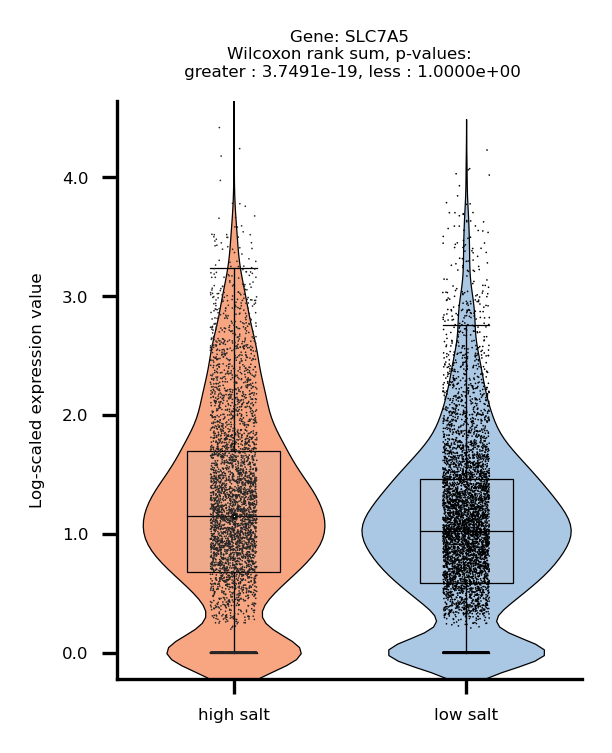

<Figure size 640x480 with 0 Axes>

In [114]:
df = gene_expression(adata, 'SLC7A5', ['high salt', 'low salt'], 'Condition', '4m', df) 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


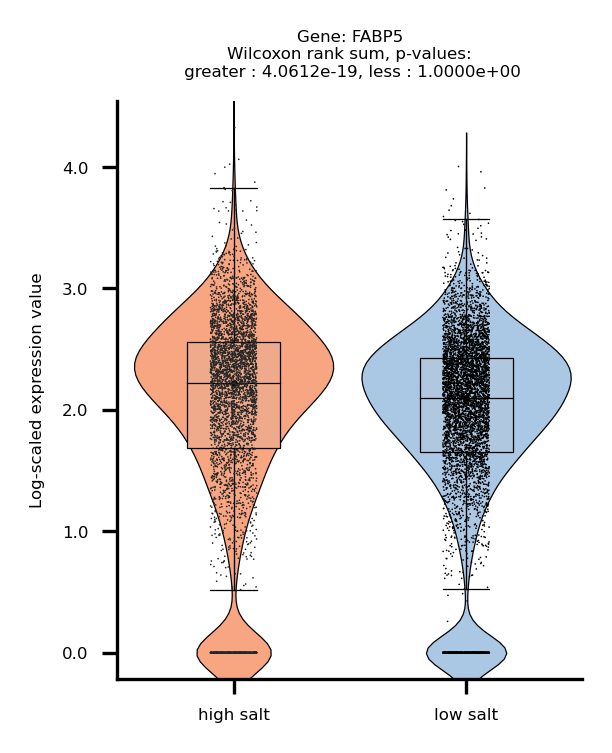

<Figure size 640x480 with 0 Axes>

In [115]:
df = gene_expression(adata, 'FABP5', ['high salt', 'low salt'], 'Condition', '4o', df) 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


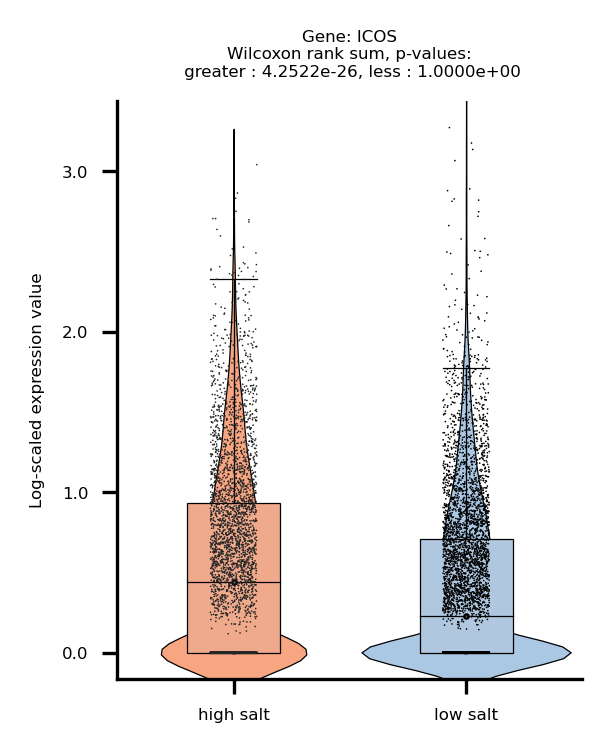

<Figure size 640x480 with 0 Axes>

In [116]:
df  = gene_expression(adata, 'ICOS', ['high salt', 'low salt'], 'Condition', 'Supplementary Figure 10a (1)', df) 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


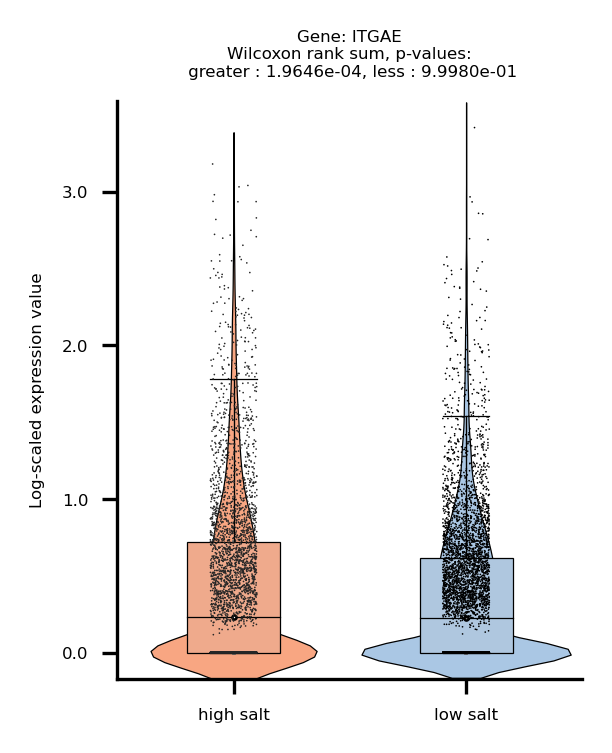

<Figure size 640x480 with 0 Axes>

In [117]:
df = gene_expression(adata, 'ITGAE', ['high salt', 'low salt'], 'Condition', 'Supplementary Figure 10a (2)', df) 

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


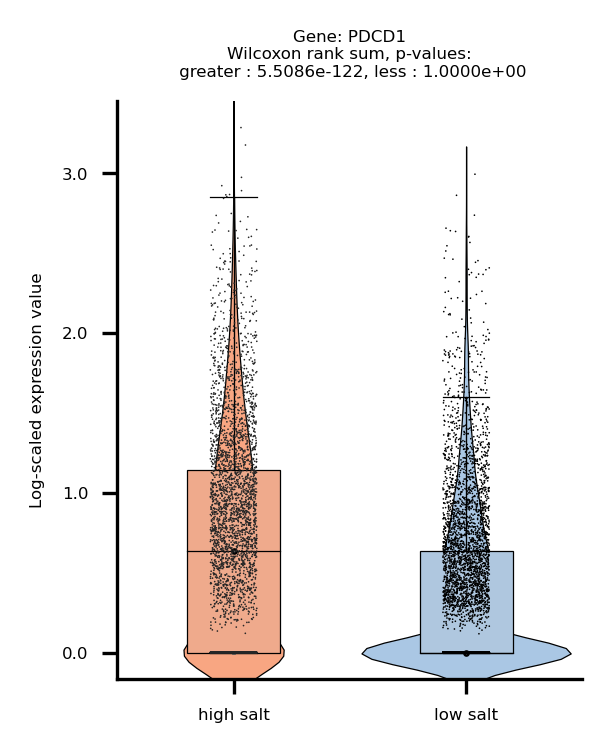

<Figure size 640x480 with 0 Axes>

In [118]:
df = gene_expression(adata, 'PDCD1', ['high salt', 'low salt'], 'Condition', 'Supplementary Figure 10a (3)', df) 

## Module score for gene sets

In [133]:
df = pd.read_csv('MAA_figures_info.csv')
df

,figure,n,type,statistical_test,min,max,q1,median,q3,lower_whisker,upper_whisker
0,1e,3,Intratumoral,one-sided,-0.095606,0.062965,-0.042722,-0.030028,-0.017055,-0.081223,0.021445
1,1e,3,Peritumoral,one-sided,-0.103136,0.035456,-0.056366,-0.041611,-0.028394,-0.098322,0.013563
2,Supplementary Figure 3,3,Intratumoral,one-sided,-0.015204,0.153822,0.041924,0.070550,0.095776,-0.015204,0.153822
3,Supplementary Figure 3,3,Peritumoral,one-sided,-0.009301,0.179613,0.032805,0.051453,0.082643,-0.009301,0.157400
4,4m,1,High NaCl,one-sided,0.000000,4.418446,0.674335,1.146571,1.700540,0.000000,3.239847
5,4m,1,Low NaCl,one-sided,0.000000,4.229486,0.589248,1.021856,1.457616,0.000000,2.760168
6,Supplementary Figure 10a (1),1,High NaCl,one-sided,0.000000,3.040958,0.000000,0.442797,0.935233,0.000000,2.338083
7,Supplementary Figure 10a (1),1,Low NaCl,one-sided,0.000000,3.271936,0.000000,0.228230,0.710968,0.000000,1.777420
8,4o,1,High NaCl,one-sided,0.000000,4.325812,1.687238,2.218847,2.555814,0.384374,3.858678
9,4o,1,Low NaCl,one-sided,0.000000,4.005136,1.652144,2.096104,2.424884,0.493034,3.583994


In [134]:
def gen_text(row):
    print(f"{row['figure']}: One-tailed wilcoxon rank sum test. {row['type']}: min={row['min']}, q1={row['q1']}, median={row['median']}, q3={row['q3']}, max={row['max']}, lower whisker={row['lower_whisker']}, upper whisker={row['upper_whisker']}")

In [119]:
marker_genes_tissue_residency = {}
column_names = []

for i in [15, 13, 11, 19, 21, 1, 9]:
    trm = pd.read_excel('../data/gene_sets/TRM_Signatures.xlsx', i)
    column_name = trm.columns[0]
    column_names.append(column_name)
    marker_genes_tissue_residency[column_name] = list(trm[column_name])[1:]

In [120]:
def module_score(adata, data_set, data_set_name, figure, df):

    sc.tl.score_genes(adata, data_set)

    low_salt = np.array(adata.obs[adata.obs.Condition == 'low salt']['score'])
    high_salt = np.array(adata.obs[adata.obs.Condition == 'high salt']['score'])

    plt.figure(figsize = (2, 2.5), dpi = 300)
    alternative = 'greater'

    dict_high = print_boxplot_stats(high_salt, "high")
    dict_low = print_boxplot_stats(low_salt, "low")
    
    dict_high['figure'] = figure
    dict_low['figure'] = figure
    
    dict_high['n'] = 1
    dict_low['n'] = 1
    
    dict_high['type'] = 'High NaCl'
    dict_low['type'] = 'Low NaCl'
    
    dict_high['statistical_test'] = 'one-sided'
    dict_low['statistical_test'] = 'one-sided'

    df = pd.concat([df, pd.DataFrame([dict_high]), pd.DataFrame([dict_low])], ignore_index=True)

    alternatives = ['two-sided', 'greater', 'less']
    
    p_values = []
    for alternative in alternatives:
        _ , p = stats.ranksums(high_salt, low_salt, alternative = alternative)
        p_values.append(p)
    p_values = [f'{i[0]} : {i[1]:.4e}' for i in list(zip(alternatives, p_values))]
    print(f'p-values:\n {", ".join(p_values)}')

    colors = ['#ffa37b', '#A7C7E7']
    customPalette = sns.set_palette(sns.color_palette(colors))

    ax = sns.violinplot(data = [high_salt, low_salt], saturation = 0.9, width = 0.9, palette = customPalette, linewidth = 0.3, kws = {'linecolor' : 'black'})
    for i, c in enumerate(ax.collections):
        ax.collections[i].set_edgecolor('black')

    sns.boxplot(data = [high_salt, low_salt], width = 0.4,
                boxprops = {'zorder': 2, 'edgecolor' : 'black'},
                capprops = {'color' : 'black'},
                whiskerprops = {'color' : 'black'},
                medianprops = {'color' : 'black'},
                showfliers = False,
                linewidth = 0.3,
                ax = ax)

    sns.stripplot(data = [high_salt, low_salt], color = 'black', ax = ax, size = 0.4)

    ax.set_ylabel(f'Module score', fontsize = 4)

    ax.set_yticklabels(ax.get_yticks(), size = 4);
    ax.set_xticklabels(ax.get_xticklabels(), size = 4);

    labels = [item.get_text() for item in ax.get_yticklabels()]

    ax.set_xticklabels(['High salt', 'Low salt'])
    ax.set_yticklabels([str(round(float(label), 2)) for label in labels])

    ax.set_title(f'{data_set_name}\nWilcoxon rank sum, p-values:\n {", ".join(p_values)}', fontsize=4)
    sns.despine()
    plt.savefig(f'../figures/violin_plot_module_score_of_{data_set_name}_genes_in_high_vs_low_salt.pdf', dpi = 300, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    return df

In [121]:
cyto1 = pd.read_csv('../data/gene_sets/cyto_list1.csv')
cyto1

,genes
0,HLA-C
1,CD1D
2,CD1E
3,SLC22A13
4,HLA-F
5,MR1
6,P2RX7
7,CD1A
8,ULBP3
9,XCL1


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 8.1781e-03, greater : 4.0890e-03, less : 9.9591e-01


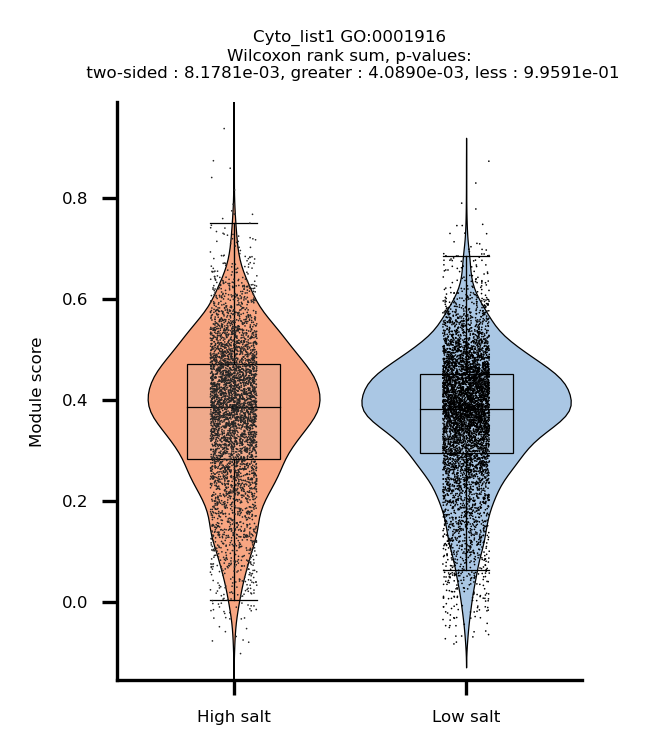

<Figure size 640x480 with 0 Axes>

In [122]:
df = module_score(adata, cyto1['genes'], 'Cyto_list1 GO:0001916', '3e', df)

In [123]:
tissure_residency_gustavo = ['XIST', 'UBC', 'LGALS3', 'MT-CO2', 'VIM', 'ANKRD28', 'RGS1', 'RGCC', 'HSPA1B', 'MT-ND4', 'HSP90Ab1', 'PPP1R15A']

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 2.2330e-88, greater : 1.1165e-88, less : 1.0000e+00


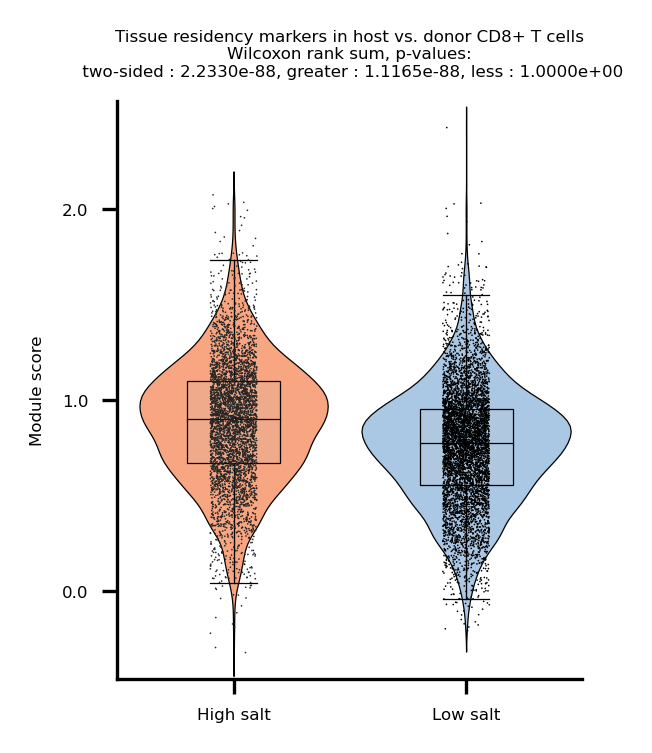

<Figure size 640x480 with 0 Axes>

In [124]:
df  = module_score(adata, tissure_residency_gustavo, 'Tissue residency markers in host vs. donor CD8+ T cells', 'Extended data 10c', df)

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 3.6865e-113, greater : 1.8433e-113, less : 1.0000e+00


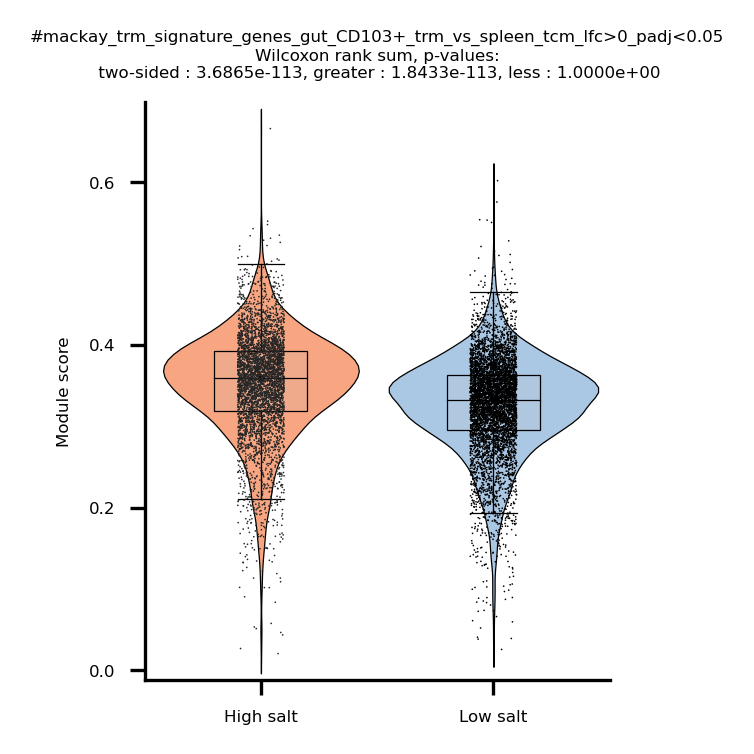

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 2.9181e-129, greater : 1.4591e-129, less : 1.0000e+00


<Figure size 640x480 with 0 Axes>

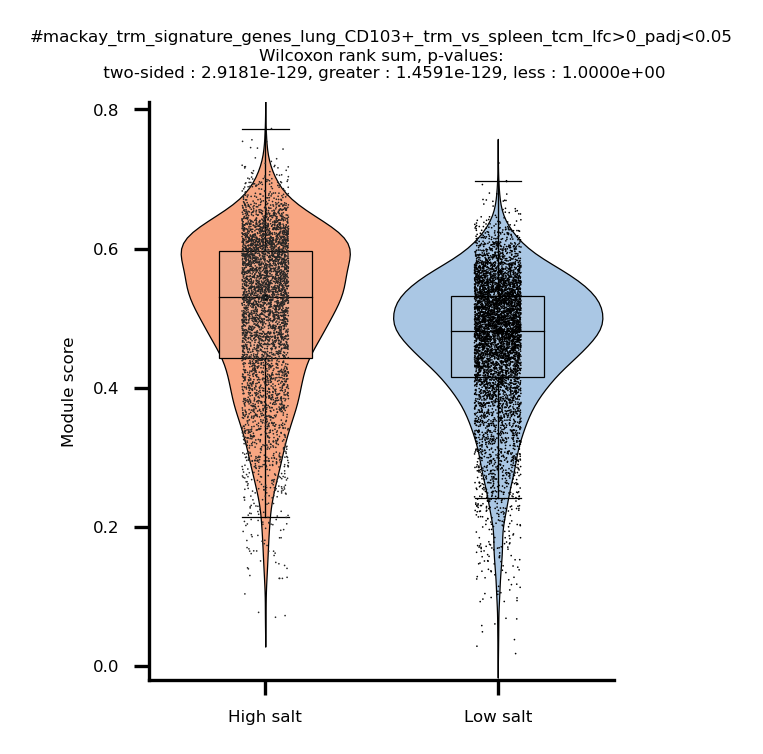

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 0.0000e+00, greater : 0.0000e+00, less : 1.0000e+00


<Figure size 640x480 with 0 Axes>

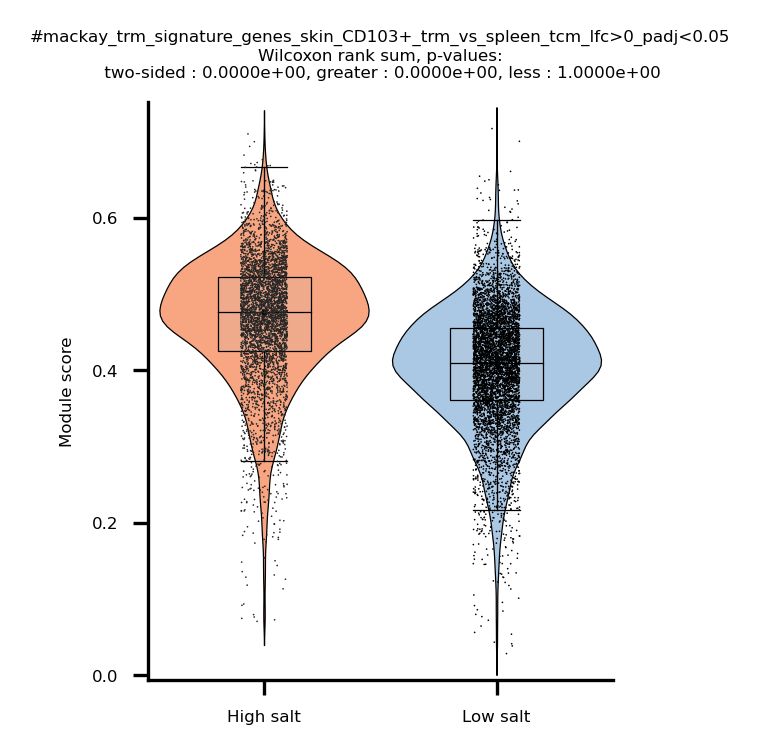

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 0.0000e+00, greater : 0.0000e+00, less : 1.0000e+00


<Figure size 640x480 with 0 Axes>

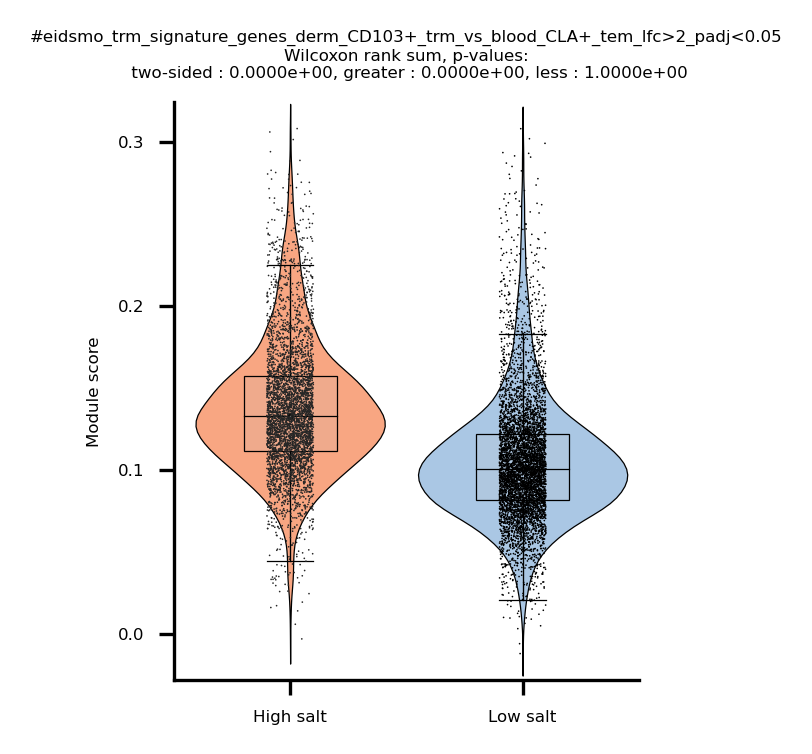

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 8.6305e-15, greater : 4.3153e-15, less : 1.0000e+00


<Figure size 640x480 with 0 Axes>

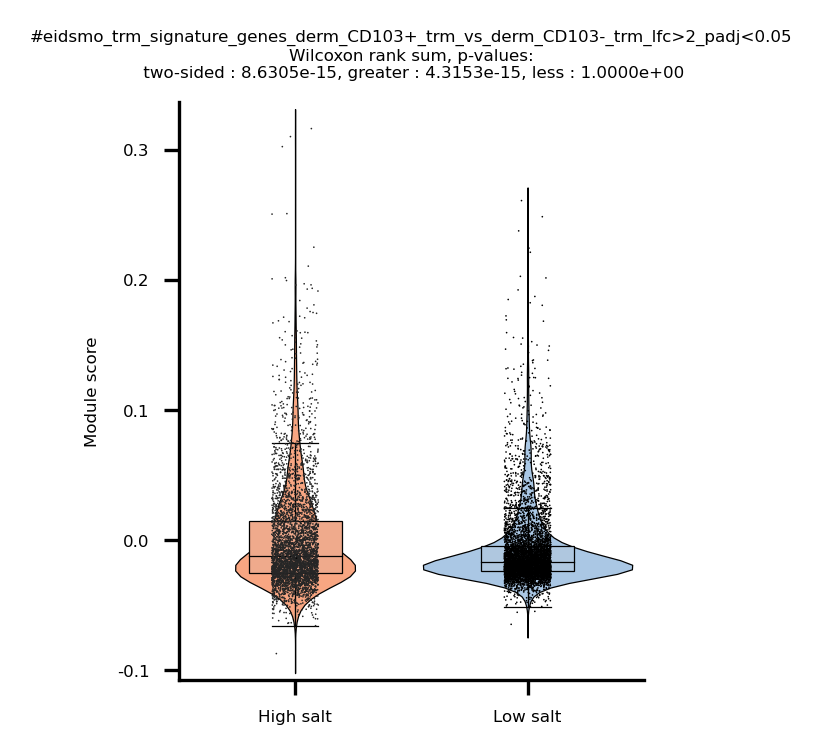

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 0.0000e+00, greater : 0.0000e+00, less : 1.0000e+00


<Figure size 640x480 with 0 Axes>

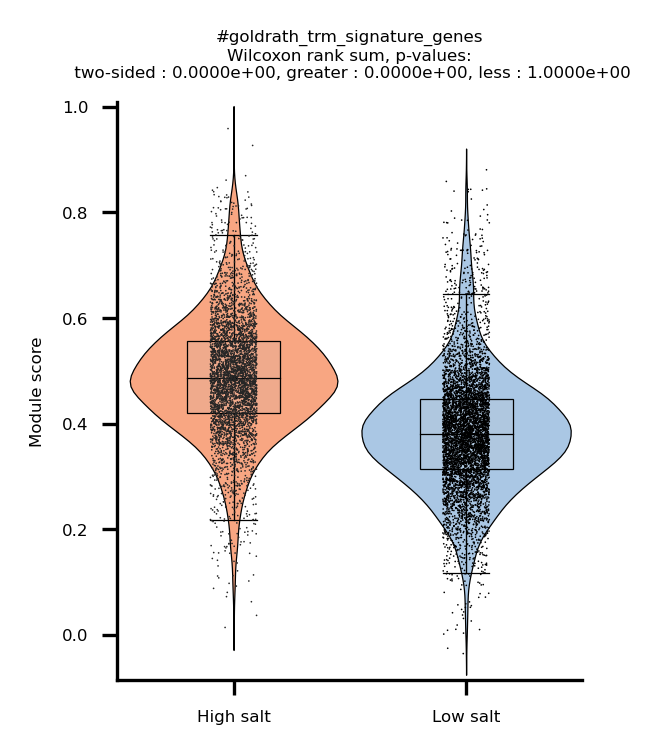

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 3.7293e-11, greater : 1.8647e-11, less : 1.0000e+00


<Figure size 640x480 with 0 Axes>

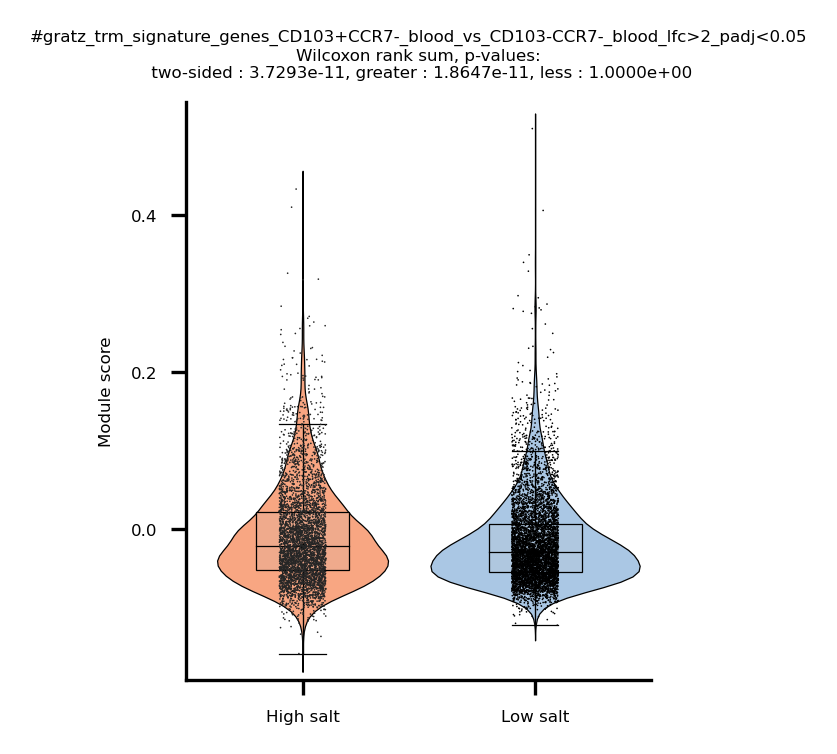

<Figure size 640x480 with 0 Axes>

In [125]:
figures_names = ['Supplementary Figure 10d (1)', 'Supplementary Figure 10d (2)', 'Supplementary Figure 10d (3)', 'Supplementary Figure 10e (1)', 'Supplementary Figure 10e (2)', 'Supplementary Figure 10f', 'Supplementary Figure 10g']
for column_name, f in zip(column_names, figures_names):
    data_set = marker_genes_tissue_residency[column_name]
    df = module_score(adata, data_set, column_name, f, df)

## GO Pathways

In [126]:
path = Path('../data/gene_sets/')

pathways = {}
for root, dirs, files in os.walk(path):
    for file in files:
        if not 'GO-0005125' in str(file): continue
        print(file)
        with open(f'{path}/{file}') as f:
            lines = f.readlines()
            genes = [line.replace('\n', '') for line in lines]
        pathway = file.replace('_', ', ').split('.')[0]
        pathways[pathway] = genes

GO-0005125.txt


GO-0005125, Number of genes: 344


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 2.0518e-270, greater : 1.0259e-270, less : 1.0000e+00


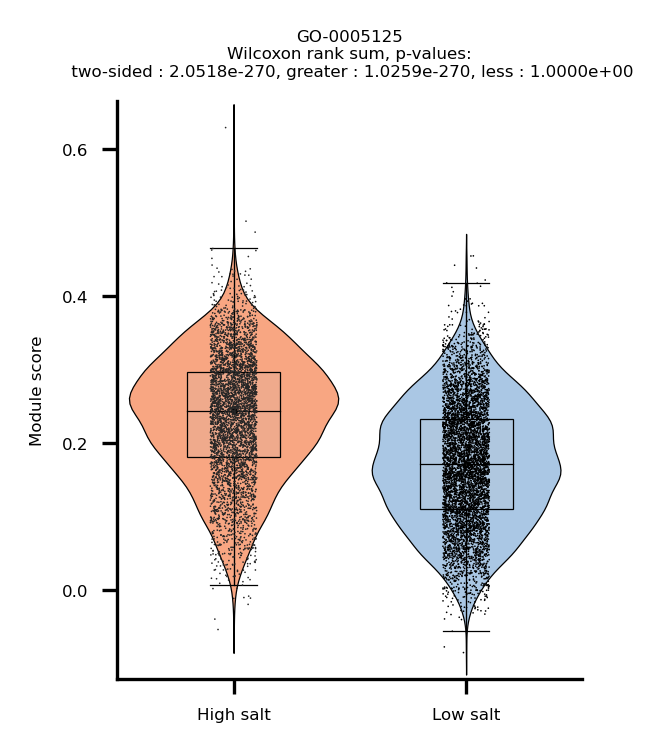

<Figure size 640x480 with 0 Axes>

In [127]:
for pathway in pathways:
    data_set = pathways[pathway]
    print(f'{pathway}, Number of genes: {len(data_set)}')
    df = module_score(adata, data_set, pathway, '3d', df)

In [128]:
exhaustion_list1 = pd.read_csv('../data/gene_sets/exhaustion_list1.csv')
exhaustion_list2 = pd.read_csv('../data/gene_sets/exhaustion_list2.csv')

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 1.4836e-27, greater : 7.4180e-28, less : 1.0000e+00


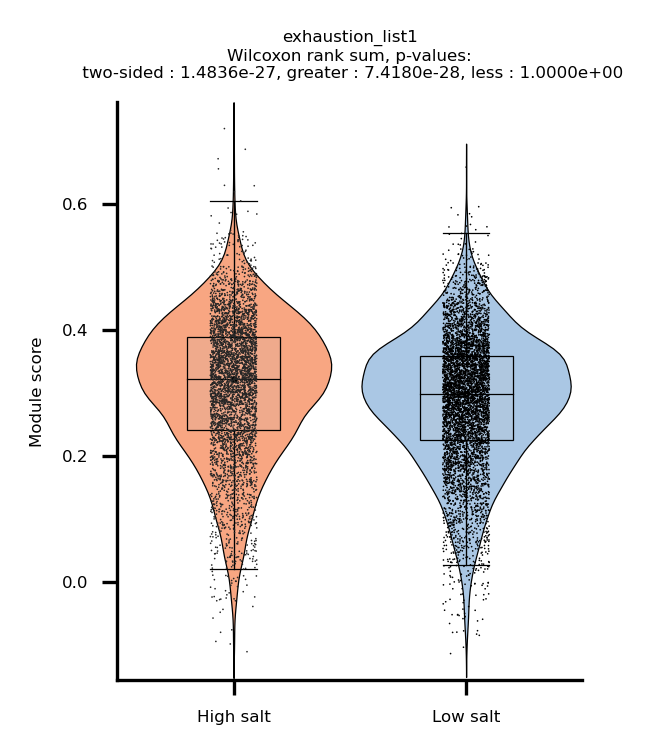

p-values:
 two-sided : 1.2887e-123, greater : 6.4433e-124, less : 1.0000e+00


Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Figure size 640x480 with 0 Axes>

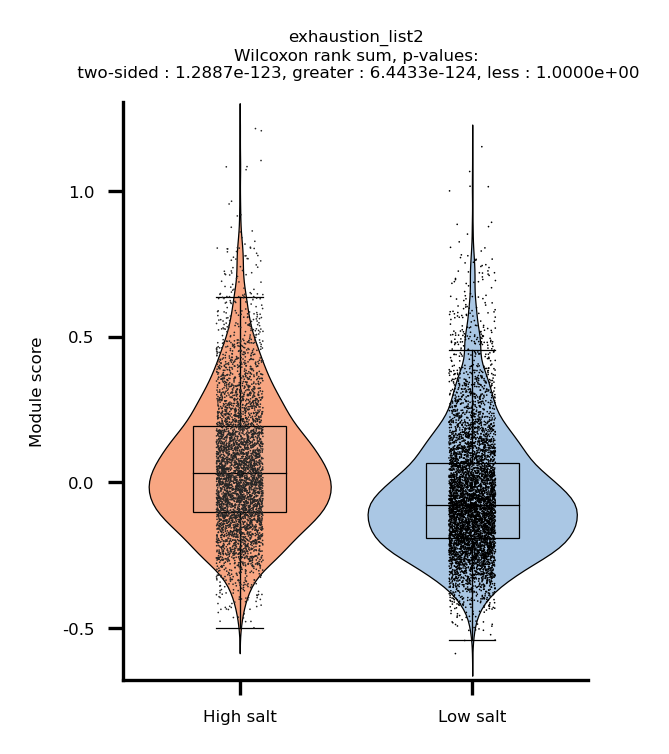

<Figure size 640x480 with 0 Axes>

In [129]:
df = module_score(adata, list(exhaustion_list1['genes']), 'exhaustion_list1', 'Supplementary Figure 10h (1)', df)
df = module_score(adata, list(exhaustion_list2['genes']), 'exhaustion_list2', 'Supplementary Figure 10h (2)', df)

In [130]:
eff_list2 = pd.read_csv('../data/gene_sets/effector_list2.csv')

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


p-values:
 two-sided : 1.7169e-261, greater : 8.5847e-262, less : 1.0000e+00


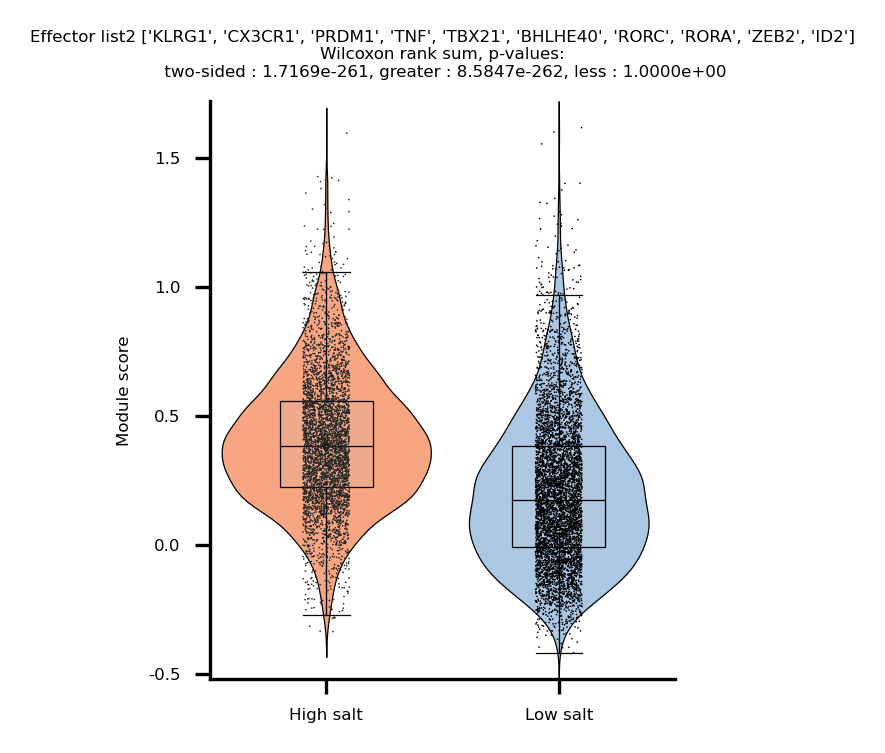

<Figure size 640x480 with 0 Axes>

In [131]:
df = module_score(adata, list(eff_list2['genes']), f'Effector list2 {list(eff_list2["genes"])}', '3c', df)

In [132]:
df.to_csv('MAA_figures_info.csv', index=False)